# LMU Model

## 1. Importing Libraries and Preprocessing Data

In [7]:
# Import libraries
import time
import numpy as np
from scipy.interpolate import make_splrep
from scipy.io import loadmat
import nengo
import nengo_dl
import numpy as np
import pandas as pd
from nengo.ensemble import Ensemble
from nengo.connection import Connection
from nengo.node import Node
import matplotlib.pyplot as plt

from nengo.utils.filter_design import cont2discrete

import sys
sys.path.append('/Users/anny/Code/Wat_ai/BCI-Signal-Decoding/src/utils')
from LMU_Stack import LMUStack

In [8]:
# Change 'monkey' variable to the desired monkey dataset: MM_S1, MT_S1, MT_S2, MT_S3
monkey = "MM_S1"

# Get Neuron data from .csv files
datafile_path = f"./../../Data Extraction/Extracted Data/{monkey}_raw.csv"
df = pd.read_csv(datafile_path)
headers = df.columns.tolist()
n_neurons = sum("Neuron" in string for string in headers)
neuron_columns = [col for col in df.columns if col.startswith('Neuron')]
activity_matrix = df[neuron_columns]
activity_matrix_t = activity_matrix.transpose().to_numpy()

kinem_matrix = df.loc[:, 'x_acceleration':'y_acceleration']
kinem_matrix_t = kinem_matrix.transpose().to_numpy()

A = activity_matrix_t    # n_neurons x n_timepoints
Y = kinem_matrix_t    # n_kinematics x n_timepoints

## 2. Building the model

Setting the model parameters

In [27]:
spikes = activity_matrix_t
scalar = np.max(kinem_matrix_t)
target_out = kinem_matrix_t/scalar 

# Model Information
dt = 0.001
dti = 1/dt
spikes = spikes*dti

# Model Parameters
n_ensemble_neurons = 3000
ensemble_radius = 1     # ? Represents the range of values for the neurons?
ensemble_synapse = 1.5
probe_synapse = 0.01
running_time = 150 # How long the model should run for
training_time = 0.8*running_time # WHen does the model stop learning

Setting LMU parameters

In [1]:
# parameters of LMU
theta = 1.0  # length of window (in seconds)
order = 4  # number of Legendre polynomials representing window
lmu_dim = 10

Building the nengo network

In [12]:
spikes.shape

(94, 1066001)

In [28]:
with nengo.Network() as model:
    
    in_node = nengo.Node(lambda t: spikes[:,int(t / dt) - 1])
    
    print(in_node.size_in)
    print(in_node.size_out)
    
    target_node = nengo.Node(lambda t: target_out[:,int(t / dt) - 1]) # expected kinematic output
    inhib_node = nengo.Node(output=lambda t: t >= training_time)
    
    
    # Low pass filter 
    rep_ens = nengo.Ensemble(spikes.shape[0], dimensions=n_neurons)
    rep_lmu_con = nengo.Connection(in_node, rep_ens, synapse=ensemble_synapse)
        
    # projecting rep to lower dimensions, and inputting into lmu
    lmu_stack = LMUStack(dim=lmu_dim, order=order, window=theta, dt=dt)
    rep_lmu_con = nengo.Connection(rep_ens, lmu_stack.input, transform=np.random.normal(1, 1, (lmu_dim, n_neurons)))
    
    # lmu output
    lmu_out_ens = nengo.Ensemble(n_ensemble_neurons, lmu_dim*order, ensemble_radius)
    print(lmu_dim*order)
    print(lmu_out_ens.dimensions)
    
    lmu_out_con = nengo.Connection(lmu_stack.output, lmu_out_ens, synapse=ensemble_synapse) 
    
    
    # Linking to output ensemble
    
    out_ens = nengo.Ensemble(lmu_dim*order, 2, ensemble_radius)
    lmu_out_con = nengo.Connection(lmu_out_ens, out_ens, synapse=ensemble_synapse, function=lambda x: [1, 1], learning_rule_type=nengo.PES(learning_rate=2e-4)) 

    # create error node and connections
    err_ens = nengo.Ensemble(n_ensemble_neurons, 2, ensemble_radius)
    out_err_con = nengo.Connection(out_ens, err_ens)
    tar_err_con = nengo.Connection(target_node, err_ens, transform=-1)
    err_lmu_lrn_con = nengo.Connection(err_ens, lmu_out_con.learning_rule)

        
    inhib_lrn_con = nengo.Connection(inhib_node, err_ens.neurons, transform=-20 * np.ones((err_ens.n_neurons, 1))) # Inhibit error ensemble once training is done to prevent weight changes after training_time

    p_out = nengo.Probe(out_ens, synapse=probe_synapse)
    p_rep = nengo.Probe(rep_ens, synapse=probe_synapse)
    p_lmu_rep = nengo.Probe(lmu_out_ens, synapse=probe_synapse)
    p_err = nengo.Probe(err_ens, synapse=probe_synapse)




0
94
40
40


Model architecture

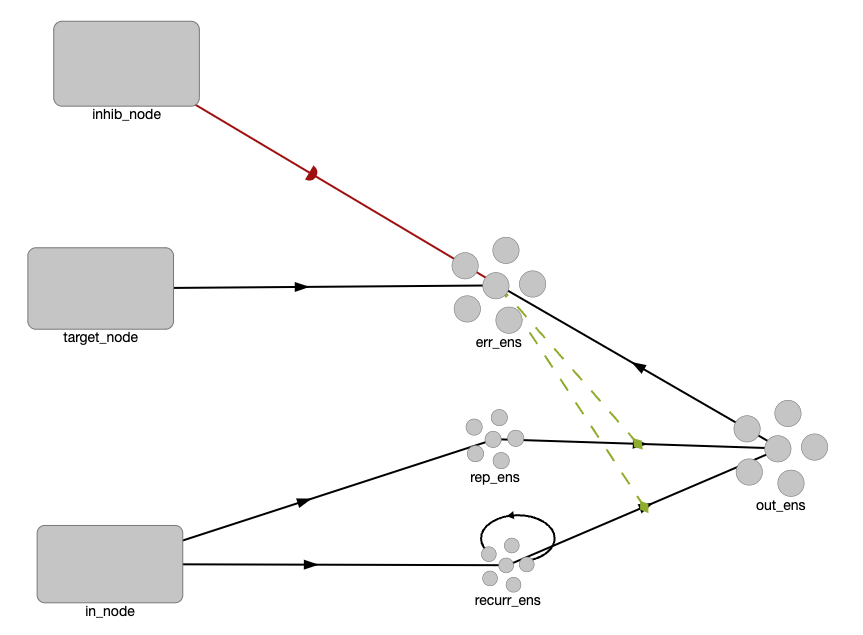

## 3. Visualizing results


In [29]:
with nengo.Simulator(model, dt=dt, seed=0) as sim:
    sim.run(running_time)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

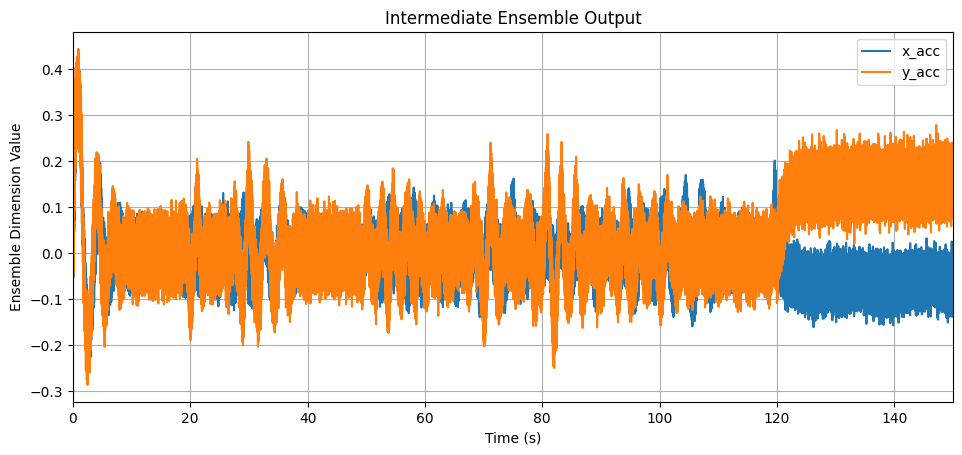

In [30]:
# For the outputs
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), sim.data[p_out])
pl.set_title("Intermediate Ensemble Output")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["x_acc", "y_acc"])
pl.grid()

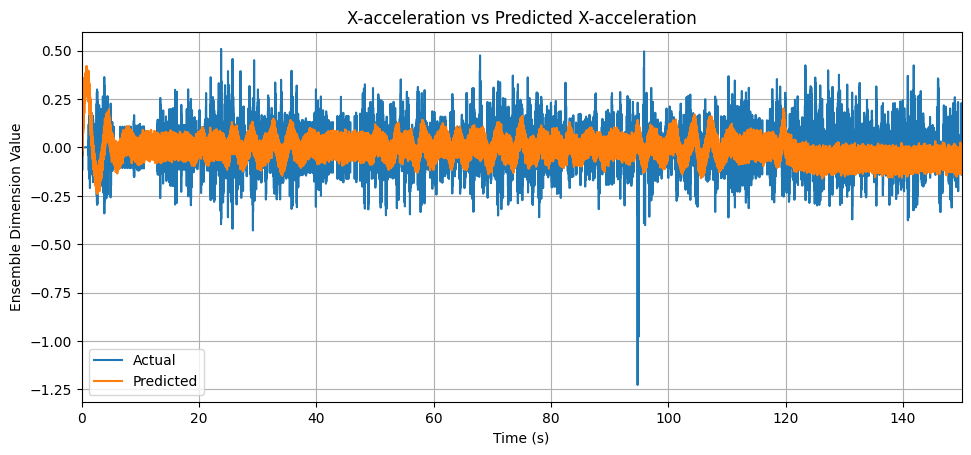

In [31]:
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), target_out[0, 0:len(sim.trange())])
pl.plot(sim.trange(), sim.data[p_out][:, 0])
pl.set_title("X-acceleration vs Predicted X-acceleration")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["Actual", "Predicted"])
pl.grid()

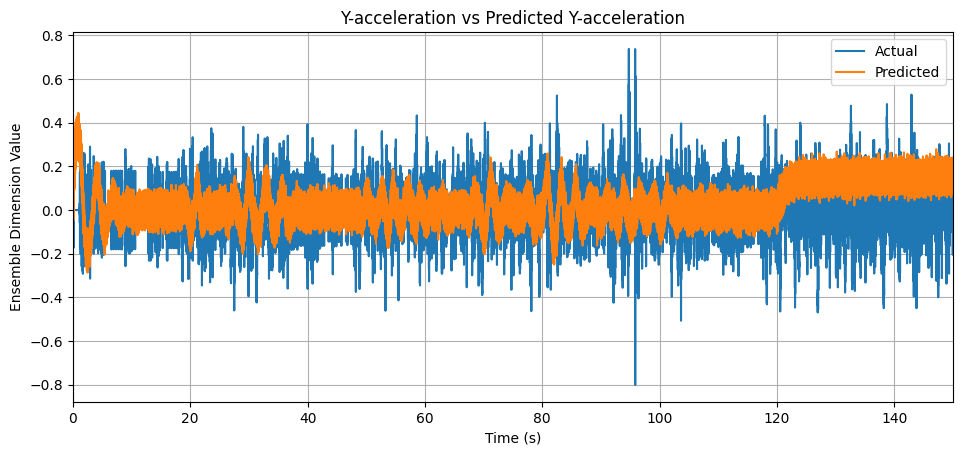

In [32]:
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), target_out[1, 0:len(sim.trange())])
pl.plot(sim.trange(), sim.data[p_out][:, 1])
pl.set_title("Y-acceleration vs Predicted Y-acceleration")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["Actual", "Predicted"])
pl.grid()

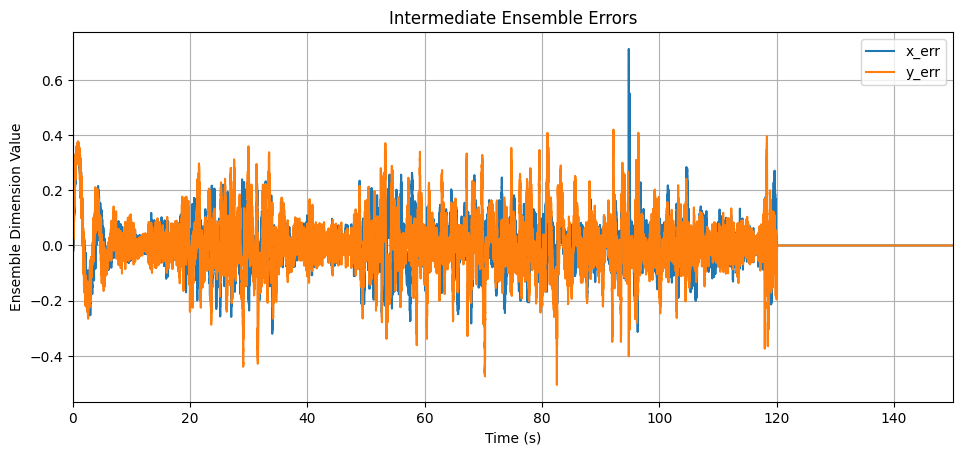

In [33]:
# For the errors
fig, pl = plt.subplots(1, 1)
fig.subplots_adjust(right=1.5)
pl.plot(sim.trange(), sim.data[p_err])
pl.set_title("Intermediate Ensemble Errors")
pl.set_xlim((0,np.max(sim.trange())))
pl.set_xlabel("Time (s)")
pl.set_ylabel("Ensemble Dimension Value")
pl.legend(["x_err", "y_err"])
pl.grid()

## 4. Evaluation

In [20]:
def GetErrors(truth, predicted):
    # ax := ground truth x acceleration, ay := ground truth y acceleration
    # sim.data[p_a] := 2-dimensional output with 0th dimension corresponding to x and 1st dimension corresponding to y
    e_mae = np.sum(np.abs(truth - predicted)) / truth.shape[0]
    e_rmse = np.sqrt(np.sum(np.power(truth - predicted, 2)) / truth.shape[0])
    print("Mean Absolute Error: " + str(e_mae))
    print("Root Mean_Squared Error: " + str(e_rmse))

In [21]:
# X-Acceleration Error
print("X-Acceleration Error")
GetErrors(target_out[0, 0:len(sim.trange())], sim.data[p_out][:, 0])
print("")

# Y-Acceleration Error
print("Y-Acceleration Error")
GetErrors(target_out[1, 0:len(sim.trange())], sim.data[p_out][:, 1])
print("")

X-Acceleration Error
Mean Absolute Error: 0.06949896535598823
Root Mean_Squared Error: 0.10517245723056581

Y-Acceleration Error
Mean Absolute Error: 0.07513137221631025
Root Mean_Squared Error: 0.1109463618013587

